In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
import math
from statistics import NormalDist, mean
from collections import ChainMap
from statannotations.Annotator import Annotator

## functions specific to handling 3D Slicer .fcsv files

In [3]:
def determineFCSVCoordSystem(input_fcsv,overwrite_fcsv=False):
	# need to determine if file is in RAS or LPS
	# loop through header to find coordinate system
	coordFlag = re.compile('# CoordinateSystem')
	verFlag = re.compile('# Markups fiducial file version')
	headFlag = re.compile('# columns')
	coord_sys=None
	headFin=None
	ver_fin=None

	with open(input_fcsv, 'r') as myfile:
		firstNlines=myfile.readlines()[0:3]

	for row in firstNlines:
		row=re.sub("[\s\,]+[\,]","",row).replace("\n","")
		cleaned_dict={row.split('=')[0].strip():row.split('=')[1].strip()}
		if None in list(cleaned_dict):
			cleaned_dict['# columns'] = cleaned_dict.pop(None)
		if any(coordFlag.match(x) for x in list(cleaned_dict)):
			coord_sys = list(cleaned_dict.values())[0]
		if any(verFlag.match(x) for x in list(cleaned_dict)):
			verString = list(filter(verFlag.match,  list(cleaned_dict)))
			assert len(verString)==1
			ver_fin = verString[0].split('=')[-1].strip()
		if any(headFlag.match(x) for x in list(cleaned_dict)):
			headFin=list(cleaned_dict.values())[0].split(',')


	if any(x in coord_sys for x in {'LPS','1'}):
		df = pd.read_csv(input_fcsv, skiprows=3, header=None)

		if df.shape[1] != 13:
			df=df.iloc[:,:14]

		df[1] = -1 * df[1] # flip orientation in x
		df[2] = -1 * df[2] # flip orientation in y

		if overwrite_fcsv:
			with open(input_fcsv, 'w') as fid:
				fid.write("# Markups fiducial file version = 4.11\n")
				fid.write("# CoordinateSystem = 0\n")
				fid.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n")

			df.rename(columns={0:'node_id', 1:'x', 2:'y', 3:'z', 4:'ow', 5:'ox',
								6:'oy', 7:'oz', 8:'vis', 9:'sel', 10:'lock',
								11:'label', 12:'description', 13:'associatedNodeID'}, inplace=True)

			df['associatedNodeID']= pd.Series(np.repeat('',df.shape[0]))
			df.round(6).to_csv(input_fcsv, sep=',', index=False, lineterminator="", mode='a', header=False, float_format='%.6f')

			print(f"Converted LPS to RAS: {os.path.dirname(input_fcsv)}/{os.path.basename(input_fcsv)}")
	return coord_sys,headFin


def df_to_fcsv(input_df, output_fcsv):
	with open(output_fcsv, 'w') as fid:
		fid.write("# Markups fiducial file version = 4.11\n")
		fid.write("# CoordinateSystem = 0\n")
		fid.write("# columns = id,x,y,z,ow,ox,oy,oz,vis,sel,lock,label,desc,associatedNodeID\n")

	out_df={'node_id':[],'x':[],'y':[],'z':[],'ow':[],'ox':[],'oy':[],'oz':[],
		'vis':[],'sel':[],'lock':[],'label':[],'description':[],'associatedNodeID':[]
	}

	for idx,ifid in input_df.iterrows():
		out_df['node_id'].append(idx+1)
		out_df['x'].append(ifid.iloc[0])
		out_df['y'].append(ifid.iloc[1])
		out_df['z'].append(ifid.iloc[2])
		out_df['ow'].append(0)
		out_df['ox'].append(0)
		out_df['oy'].append(0)
		out_df['oz'].append(0)
		out_df['vis'].append(1)
		out_df['sel'].append(1)
		out_df['lock'].append(1)
		out_df['label'].append(str(ifid.iloc[3]))
		out_df['description'].append(str(ifid.iloc[4]))
		out_df['associatedNodeID'].append('1')

	out_df=pd.DataFrame(out_df)
	out_df.to_csv(output_fcsv, sep=',', index=False, lineterminator="", mode='a', header=False, float_format = '%.3f')

## Identifying sub-groups of electrodes (ex. Am or Amygdala, AHc or Anterior Hippocampus from coordinate label)

In [4]:
def sorted_nicely(lst):
	convert = lambda text: int(text) if text.isdigit() else text
	alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
	sorted_lst = sorted(lst, key = alphanum_key)

	return sorted_lst

def determine_groups(iterable, numbered_labels=False):
	values = []
	for item in iterable:
		temp=None
		if re.findall(r"([a-zA-Z]+)([0-9]+)([a-zA-Z]+)", item):
			temp = "".join(list(re.findall(r"([a-zA-Z]+)([0-9]+)([a-zA-Z]+)", item)[0]))
		elif '-' in item:
			temp=item.split('-')[0]
		else:
			if numbered_labels:
				temp=''.join([x for x in item if not x.isdigit()])
				for sub in ("T1","T2"):
					if sub in item:
						temp=item.split(sub)[0] + sub
			else:
				temp=item
		if temp is None:
			temp=item

		values.append(temp)

	vals,indexes,count = np.unique(values, return_index=True, return_counts=True)
	values_unique = [values[index] for index in sorted(indexes)]

	return values_unique,vals

# Metrics

In [5]:
def euclidianDistanceCalc(xyz_planned, xyz_actual):
	##greydon/jon
  #print(xyz_planned.ndim)
	if xyz_planned.ndim>1:
		euc_dist=[]
		for ipoint in range(xyz_planned.shape[0]):
			plan_act_diff = xyz_planned[ipoint] - xyz_actual[ipoint]
			euc_dist.append(math.sqrt(sum(plan_act_diff**2)))
	else:
		plan_act_diff = xyz_planned - xyz_actual
		euc_dist = math.sqrt(sum(plan_act_diff**2))
	return euc_dist


def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def radialDistanceCalc(pt, xyz_entry, xyz_target):
    if xyz_entry.ndim > 1:
        dist3d = []
        for ipoint in range(xyz_entry.shape[0]):
            x1_minus_pt = pt[ipoint] - xyz_entry[ipoint]
            x2_minus_x1 = xyz_target[ipoint] - xyz_entry[ipoint]

            sumsq_x1_minus_pt = sum(x1_minus_pt * x1_minus_pt)
            sumsq_x2_minus_x1 = sum(x2_minus_x1 * x2_minus_x1)

            mydotprod = np.dot(x1_minus_pt, x2_minus_x1)

            dist3d.append(np.sqrt(
                (sumsq_x1_minus_pt * sumsq_x2_minus_x1 - (mydotprod * mydotprod))/sumsq_x2_minus_x1))
    else:
        x1_minus_pt = pt - xyz_entry
        x2_minus_x1 = xyz_target - xyz_entry

        sumsq_x1_minus_pt = sum(x1_minus_pt * x1_minus_pt)
        sumsq_x2_minus_x1 = sum(x2_minus_x1 * x2_minus_x1)

        mydotprod = np.dot(x1_minus_pt, x2_minus_x1)

        dist3d = np.sqrt((sumsq_x1_minus_pt * sumsq_x2_minus_x1 -
                         (mydotprod * mydotprod))/sumsq_x2_minus_x1)
    return dist3d


def ptLineAngleCalc(pt, x_entry, x_target):
    if x_entry.ndim > 1:
        deg_angle = []
        for ipoint in range(x_entry.shape[0]):
            try:
                x1_minus_pt = pt[ipoint] - x_entry[ipoint]
                x2_minus_x1 = x_target[ipoint] - x_entry[ipoint]

                sumsq_x1_minus_pt = sum(x1_minus_pt**2)
                sumsq_x2_minus_x1 = sum(x2_minus_x1**2)

                # sum of products of elements
                mydotprod = np.dot(x1_minus_pt, x2_minus_x1)

                rad_angle = math.acos(
                    mydotprod/(np.sqrt(sumsq_x1_minus_pt)*np.sqrt(sumsq_x2_minus_x1)))
                deg_angle.append(math.degrees(rad_angle))
            except:
                deg_angle.append(np.nan)
                print(f"Check point {ipoint}")
    else:
        x1_minus_pt = pt - x_entry
        x2_minus_x1 = x_target - x_entry

        sumsq_x1_minus_pt = sum(x1_minus_pt**2)
        sumsq_x2_minus_x1 = sum(x2_minus_x1**2)

        # sum of products of elements
        mydotprod = np.dot(x1_minus_pt, x2_minus_x1)

        rad_angle = math.acos(
            mydotprod/(np.sqrt(sumsq_x1_minus_pt)*np.sqrt(sumsq_x2_minus_x1)))
        deg_angle = math.degrees(rad_angle)
    return deg_angle

# Line angle calculation


def lineLineAngleCalc(a_entry, a_target, b_entry, b_target):
    if a_entry.ndim > 1:
        deg_angle = []
        for ipoint in range(a_entry.shape[0]):
            try:
                vectorA = a_target[ipoint] - a_entry[ipoint]
                vectorB = b_target[ipoint] - b_entry[ipoint]

                sumsq_vectorA = sum(vectorA**2)
                sumsq_vectorB = sum(vectorB**2)

                mydotprod = sum(vectorA*vectorB)

                rad_angle = math.acos(
                    mydotprod/(np.sqrt(sumsq_vectorA)*np.sqrt(sumsq_vectorB)))
                deg_angle.append(math.degrees(rad_angle))
            except:
                deg_angle.append(np.nan)
                print(f"Check point {ipoint}")
    else:
        vectorA = a_target - a_entry
        vectorB = b_target - b_entry

        sumsq_vectorA = sum(vectorA**2)
        sumsq_vectorB = sum(vectorB**2)

        mydotprod = sum(vectorA*vectorB)

        rad_angle = math.acos(
            mydotprod/(np.sqrt(sumsq_vectorA)*np.sqrt(sumsq_vectorB)))
        deg_angle = math.degrees(rad_angle)
    return deg_angle

def normDir(direction):
  return np.array(direction) / np.linalg.norm(np.array(direction))

def mag_vec(P1, P2):
  if isinstance(P1, list):
    P1 = np.array(P1)
  if isinstance(P1, list):
    P2 = np.array(P2)
  DirVec = P2-P1
  MagVec = np.sqrt([np.square(DirVec[0]) + np.square(DirVec[1]) + np.square(DirVec[2])])
  return MagVec

def norm_vec(P1, P2):
  if isinstance(P1, list):
    P1 = np.array(P1)
  if isinstance(P2, list):
    P2 = np.array(P2)
  DirVec = P2-P1
  MagVec = np.sqrt([np.square(DirVec[0]) + np.square(DirVec[1]) + np.square(DirVec[2])])
  NormVec = np.array([float(DirVec[0] / MagVec), float(DirVec[1] / MagVec), float(DirVec[2] / MagVec)])
  return NormVec

def mean_confidence_interval(data, confidence=0.95):
	dist = NormalDist.from_samples(data[~np.isnan(data)])
	z = NormalDist().inv_cdf((1 + confidence) / 2.)
	h = dist.stdev * z / ((len(data) - 1) ** .5)
	return dist.mean - h, dist.mean + h

In [6]:
root_dir = './data'

In [7]:
subjects = [identifier[:8] for identifier in os.listdir(root_dir) if "sub-" in identifier]
print(len(subjects))

246


In [8]:
frame_subjects = [sub for sub in subjects if sub.startswith('sub-F')]
print(len(frame_subjects))

28


# QC Subjects - Confirm Coordinate System

In [9]:
for subject in sorted(subjects):
  planned_fcsv = f'{root_dir}/{subject}/{subject}_planned.fcsv'
  actual_fcsv = f'{root_dir}/{subject}/{subject}_actual.fcsv'
  if glob.glob(planned_fcsv) and glob.glob(actual_fcsv):
    planned_coordsym, planned_headFin = determineFCSVCoordSystem(planned_fcsv)
    if any(x in planned_coordsym for x in {'LPS','1'}):
      print(f'Planned is in LPS for {subject}')
    actual_coordsym, actual_headFin = determineFCSVCoordSystem(actual_fcsv)
    if any(x in actual_coordsym for x in {'LPS','1'}):
      print(f'Actual is in LPS for {subject}')
  else:
    print(f"Files not found, review {subject}")

Files not found, review sub-P158


In [10]:
total_data = []
frame_data = []
for sub in sorted(subjects):
  elec_data=[]
  #print(sub)
  planned_fcsv = f'{root_dir}/{sub}/{sub}_planned.fcsv'
  actual_fcsv = f'{root_dir}/{sub}/{sub}_actual.fcsv'
  if not glob.glob(planned_fcsv) or not glob.glob(actual_fcsv):
    print(f"Files not found, review {sub}")
    continue
  coord_sys,headFin=determineFCSVCoordSystem(planned_fcsv, overwrite_fcsv=True)

  planned_df = pd.read_csv(planned_fcsv, skiprows=3, header=None)
  actual_df = pd.read_csv(actual_fcsv, skiprows=3, header=None)

  head_info=dict(ChainMap(*[{i:x} for i,x in enumerate(headFin)]))

  planned_df=planned_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)
  actual_df=actual_df.iloc[:,:].rename(columns=head_info).reset_index(drop=True)

  groups_planned, planned_all = determine_groups(np.array(planned_df['label'].values))
  label_set=sorted(set(groups_planned), key=groups_planned.index)

  groups_actual, actual_all = determine_groups(np.array(actual_df['label'].values))
  label_set_actual=sorted(set(groups_actual), key=groups_actual.index)

  for group in label_set_actual:
    elec_temp={}
    elec_temp['subject']=sub
    elec_temp['electrode']=group
    elec_temp['group']=group[1:]
    elec_temp['side']='L' if group.startswith('L') else 'R'

    planned_idx = [i for i,x in enumerate(planned_df['label'].values) if x.startswith(group)]
    elec_temp['plannedTipX']=planned_df.loc[planned_idx,'x'].values[0]
    elec_temp['plannedTipY']=planned_df.loc[planned_idx,'y'].values[0]
    elec_temp['plannedTipZ']=planned_df.loc[planned_idx,'z'].values[0]
    elec_temp['plannedEntryX']=planned_df.loc[planned_idx,'x'].values[1]
    elec_temp['plannedEntryY']=planned_df.loc[planned_idx,'y'].values[1]
    elec_temp['plannedEntryZ']=planned_df.loc[planned_idx,'z'].values[1]

    actual_idx=[i for i,x in enumerate(actual_df['label'].values) if x.startswith(group)]
    elec_temp['actualTipX']=actual_df.loc[actual_idx,'x'].values[0]
    elec_temp['actualTipY']=actual_df.loc[actual_idx,'y'].values[0]
    elec_temp['actualTipZ']=actual_df.loc[actual_idx,'z'].values[0]
    elec_temp['actualEntryX']=actual_df.loc[actual_idx,'x'].values[1]
    elec_temp['actualEntryY']=actual_df.loc[actual_idx,'y'].values[1]
    elec_temp['actualEntryZ']=actual_df.loc[actual_idx,'z'].values[1]

    # mag = mag_vec(planned_df.loc[planned_idx,['x','y','z']].values[0],
    #               planned_df.loc[planned_idx,['x','y','z']].values[1])
    # norm = norm_vec(planned_df.loc[planned_idx,['x','y','z']].values[0],
    #                 planned_df.loc[planned_idx,['x','y','z']].values[1])
    # plannedTipOffset=planned_df.loc[planned_idx,['x','y','z']].values[1]-(norm*(mag-1))

    # elec_temp['plannedOffsetX']=plannedTipOffset[0]
    # elec_temp['plannedOffsetY']=plannedTipOffset[1]
    # elec_temp['plannedOffsetZ']=plannedTipOffset[2]

    # elec_temp['plannedOffsetX']=elec_temp['plannedTipX']
    # elec_temp['plannedOffsetY']=elec_temp['plannedTipY']
    # elec_temp['plannedOffsetZ']=elec_temp['plannedTipZ']

    xyz_planned_entry = np.array([elec_temp['plannedEntryX'], elec_temp['plannedEntryY'], elec_temp['plannedEntryZ']])
    xyz_actual_entry = np.array([elec_temp['actualEntryX'], elec_temp['actualEntryY'], elec_temp['actualEntryZ']]).T
    xyz_planned_target = np.array([elec_temp['plannedTipX'], elec_temp['plannedTipY'], elec_temp['plannedTipZ']]).T
    xyz_actual_target = np.array([elec_temp['actualTipX'], elec_temp['actualTipY'], elec_temp['actualTipZ']]).T

    elec_temp['euclid_dist_target'] = round(euclidianDistanceCalc(xyz_planned_target, xyz_actual_target), 3)
    elec_temp['euclid_dist_entry'] = round(euclidianDistanceCalc(xyz_planned_entry, xyz_actual_entry), 3)
    elec_temp['radial_dist_target'] = round(radialDistanceCalc(xyz_planned_target, xyz_actual_entry, xyz_actual_target), 3)
    elec_temp['radial_dist_entry'] = round(radialDistanceCalc(xyz_planned_entry, xyz_actual_entry, xyz_actual_target), 3)

    if not np.array_equal(np.round(xyz_actual_target,2), np.round(xyz_planned_target,2)):
      try:
        elec_temp['radial_angle'] = ptLineAngleCalc(xyz_actual_target, xyz_planned_entry, xyz_planned_target)
        elec_temp['line_angle'] = lineLineAngleCalc(xyz_actual_entry, xyz_actual_target, xyz_planned_entry, xyz_planned_target)
      except:
        pass
    elec_data.append(elec_temp)
  elec_data_raw=pd.DataFrame(elec_data)
  elec_table=elec_data_raw[['electrode','euclid_dist_target', 'radial_dist_target', 'euclid_dist_entry','radial_dist_entry','radial_angle','line_angle']].round(2)

  # elec_table.to_csv(f'{root_dir}/{sub}/{sub}_accuracy.csv', index=False)

  if sub.startswith('sub-F'):
    frame_data.append(elec_data)
  else:
    total_data.append(elec_data)



SyntaxError: '(' was never closed (4029238021.py, line 72)

In [ ]:
flattened_data = [item for sublist in total_data for item in sublist]

robot = pd.DataFrame(flattened_data)

robot = robot.explode(['electrode', 'group', 'side', 'radial_angle', 'line_angle',
                     'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target'])


flattened_frame = [item for sublist in frame_data for item in sublist]

frame = pd.DataFrame(flattened_frame)

frame = frame.explode(['electrode', 'group', 'side', 'radial_angle', 'line_angle',
                     'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target'])

In [ ]:
# robot.to_csv(f'{root_dir}/2025_SEEG_robot_accuracy.csv', index=False)
# frame.to_csv(f'{root_dir}/2025_SEEG_frame_accuracy.csv', index=False)

In [ ]:
robot_simple = robot[['subject', 'electrode', 'group', 'side',
                    'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target']]

robot_simple

,subject,electrode,group,side,euclid_dist_entry,radial_dist_entry,euclid_dist_target,radial_dist_target
0,sub-D098,LPHc,PHc,L,2.901827,2.672586,4.925825,4.925825
1,sub-D098,LPOFr,POFr,L,1.542534,1.287479,1.841181,1.779609
2,sub-D098,LAOFr,AOFr,L,1.578667,1.254961,1.994809,1.992756
3,sub-D098,LAIn,AIn,L,0.442399,0.077632,3.296466,3.071157
4,sub-D098,LMesFr,MesFr,L,0.808607,0.724334,0.784254,0.766073
...,...,...,...,...,...,...,...,...
2642,sub-P157,LACg,ACg,L,1.620614,1.619653,1.988243,1.957874
2643,sub-P157,LAHc,AHc,L,0.833267,0.833242,3.939549,3.144574
2644,sub-P157,LPHc,PHc,L,1.211791,0.496972,1.154056,0.808584
2645,sub-P157,LOpCav,OpCav,L,2.209247,0.991278,1.817033,1.174915


In [ ]:
robot_simple.describe()

,euclid_dist_entry,radial_dist_entry,euclid_dist_target,radial_dist_target
count,2647.000000,2647.000000,2647.000000,2647.000000
mean,1.700992,1.274613,2.224194,1.650327
std,1.762914,1.559880,2.067766,1.632407
min,0.000000,0.000000,0.000000,0.000000
25%,0.909975,0.651354,1.344809,0.870481
50%,1.389660,1.063851,1.901340,1.369194
75%,2.024198,1.539951,2.655002,2.027772
max,32.976725,32.973957,54.361584,51.762894


In [ ]:
frame_simple = frame[['subject', 'electrode', 'group', 'side',
                    'euclid_dist_entry',  'radial_dist_entry', 'euclid_dist_target', 'radial_dist_target']]

In [ ]:
frame_simple

,subject,electrode,group,side,euclid_dist_entry,radial_dist_entry,euclid_dist_target,radial_dist_target
0,sub-F001,LAHc,AHc,L,1.163340,0.783690,3.394373,3.185347
1,sub-F001,LAm,Am,L,2.454068,2.236614,2.747414,2.643766
2,sub-F001,LEc,Ec,L,1.841101,1.546167,3.494612,3.471868
3,sub-F001,LMiHc,MiHc,L,0.859168,0.579847,1.781761,1.107764
4,sub-F001,LPHcGy,PHcGy,L,0.914539,0.854622,1.594755,1.508697
...,...,...,...,...,...,...,...,...
284,sub-F031,LPHc,PHc,L,2.193379,2.094486,2.838969,2.371344
285,sub-F031,LPIn,PIn,L,3.162144,1.266572,2.914281,2.628057
286,sub-F031,LTeOp,TeOp,L,1.932670,1.296126,2.611280,2.598375
287,sub-F031,RAHc,AHc,R,1.411097,1.379100,1.676392,1.261419


In [ ]:
frame_simple.describe()

,euclid_dist_entry,radial_dist_entry,euclid_dist_target,radial_dist_target
count,289.000000,289.000000,289.000000,289.000000
mean,2.556986,2.071542,3.108066,2.413517
std,2.023127,1.436612,2.229980,2.019328
min,0.000000,0.000000,0.279105,0.084007
25%,1.294812,1.102128,1.769556,1.049711
50%,2.153930,1.811481,2.598160,2.129889
75%,3.203331,2.632121,3.684644,3.093364
max,21.103796,8.720960,19.833223,19.559593


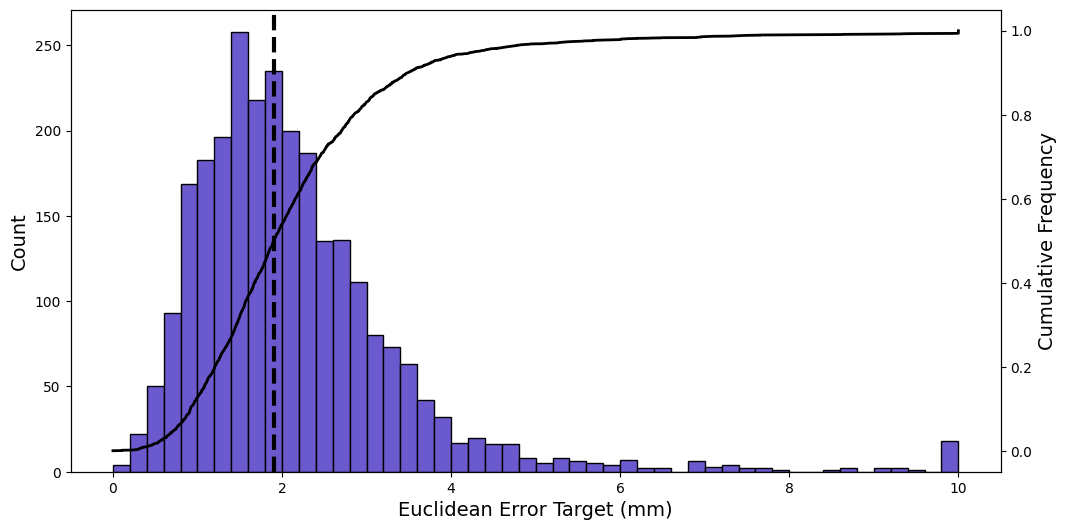

In [ ]:
thresh = 10
df1 = frame_simple['euclid_dist_target']
df2 = robot_simple['euclid_dist_target']
# Flatten and clip the DataFrames to create 1D arrays
data1 = np.clip(df1.to_numpy().flatten(), a_min=None, a_max=thresh)
data2 = np.clip(df2.to_numpy().flatten(), a_min=None, a_max=thresh)
# Calculate cumulative frequencies
data1_sorted = np.sort(data1)
cumulative_frequency1 = np.arange(1, len(data1_sorted) + 1) / len(data1_sorted)
data2_sorted = np.sort(data2)
cumulative_frequency2 = np.arange(1, len(data2_sorted) + 1) / len(data2_sorted)


bins = np.linspace(0, thresh, num=51)

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.hist([data2], bins, label=['Robot'], edgecolor='black', linewidth=1, color = ['slateblue'])
ax1.set_xlabel('Euclidean Error Target (mm)', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)

ax2 = ax1.twinx()
# ax2.plot(data1_sorted, cumulative_frequency1, color='blue', linestyle='-', linewidth=2, label='Cumulative Frequency Method 1')
ax2.plot(data2_sorted, cumulative_frequency2, color='black', linestyle='-', linewidth=2, label='Cumulative Frequency Method 2')
ax2.set_ylabel('Cumulative Frequency', fontsize=14)

median1 = np.median(data1_sorted)
median2 = np.median(data2_sorted)
# ax1.axvline(median1, linestyle='--',color = 'blue', linewidth=2, label='SEEGA')
ax1.axvline(median2, linestyle='--', color = 'black', linewidth=3, label='Robot')
handles, labels = ax1.get_legend_handles_labels()
# Filter out the handles and labels to only include those for the histograms
handles = [h for h, l in zip(handles, labels) if 'Method' in l]
labels = [l for l in labels if 'Method' in l]
# ax1.legend(handles=handles, labels=labels, loc='center', borderaxespad=0.)
# ax1.set_xticks(np.arange(0, thresh, 0.1))


plt.show()

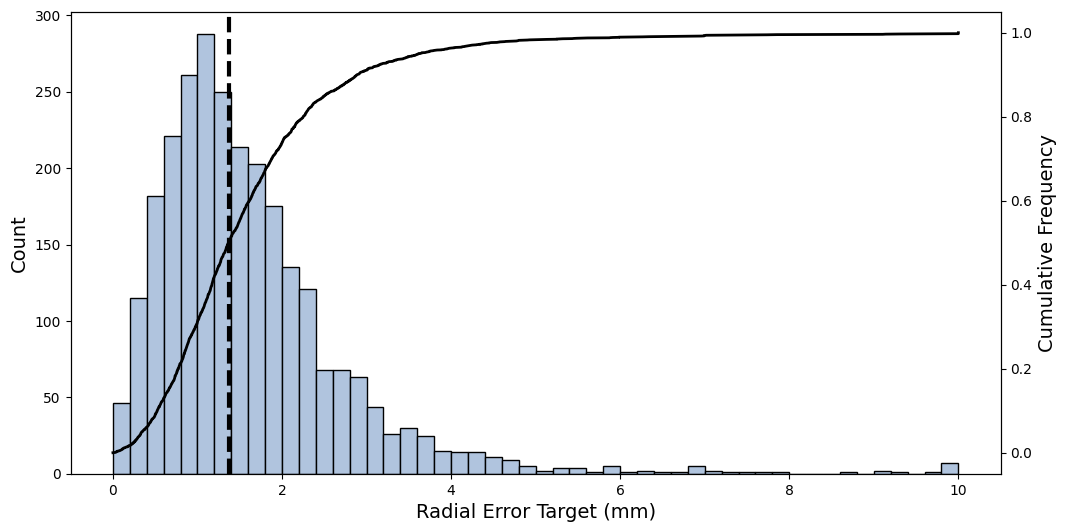

In [ ]:
thresh = 10
df1 = frame_simple['radial_dist_target']
df2 = robot_simple['radial_dist_target']
# Flatten and clip the DataFrames to create 1D arrays
data1 = np.clip(df1.to_numpy().flatten(), a_min=None, a_max=thresh)
data2 = np.clip(df2.to_numpy().flatten(), a_min=None, a_max=thresh)
# Calculate cumulative frequencies
data1_sorted = np.sort(data1)
cumulative_frequency1 = np.arange(1, len(data1_sorted) + 1) / len(data1_sorted)
data2_sorted = np.sort(data2)
cumulative_frequency2 = np.arange(1, len(data2_sorted) + 1) / len(data2_sorted)


bins = np.linspace(0, thresh, num=51)

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.hist([data2], bins, label=['Robot'], edgecolor='black', linewidth=1, color = ['lightsteelblue'])
ax1.set_xlabel('Radial Error Target (mm)', fontsize=14)
ax1.set_ylabel('Count', fontsize=14)

ax2 = ax1.twinx()
# ax2.plot(data1_sorted, cumulative_frequency1, color='blue', linestyle='-', linewidth=2, label='Cumulative Frequency Method 1')
ax2.plot(data2_sorted, cumulative_frequency2, color='black', linestyle='-', linewidth=2, label='Cumulative Frequency Method 2')
ax2.set_ylabel('Cumulative Frequency', fontsize=14)

median1 = np.median(data1_sorted)
median2 = np.median(data2_sorted)
# ax1.axvline(median1, linestyle='--',color = 'blue', linewidth=2, label='SEEGA')
ax1.axvline(median2, linestyle='--', color = 'black', linewidth=3, label='Robot')
handles, labels = ax1.get_legend_handles_labels()
# Filter out the handles and labels to only include those for the histograms
handles = [h for h, l in zip(handles, labels) if 'Method' in l]
labels = [l for l in labels if 'Method' in l]
# ax1.legend(handles=handles, labels=labels, loc='center', borderaxespad=0.)
# ax1.set_xticks(np.arange(0, thresh, 0.1))


plt.show()